In [8]:
# import libs
import boto3
import json
from PIL import Image
import io

In [9]:
client = boto3.client("lambda")

s3 = boto3.client("s3")

In [10]:
def fetch_image(bucket: str, key: str) -> Image:
    response = s3.get_object(Bucket=bucket, Key=key)
    image_data = response["Body"].read()
    image = Image.open(io.BytesIO(image_data))
    return image

def combine_images_horizontally(images):
    # すべての画像の幅と高さを計算
    total_width = sum(image.width for image in images)
    max_height = max(image.height for image in images)

    # 新しい画像のキャンバスを作成
    new_image = Image.new('RGB', (total_width, max_height))

    # 各画像を新しい画像に貼り付け
    x_offset = 0
    for image in images:
        new_image.paste(image, (x_offset, 0))
        x_offset += image.width

    # 最終的な画像を表示
    new_image.show()


def invoke_lambda(payload:dict):
    response = client.invoke(
        FunctionName="aska-api-dev-ImageDiffHandler",
        InvocationType="RequestResponse",
        LogType="Tail",
        Payload=bytes(json.dumps(payload).encode()),
    )
    print(response["Payload"].read().decode("utf-8"))

def main(payload:dict):
    id,page = (payload["body"]["before"]["image_object_key"]).split('/')

    bucket_name = payload["body"]["bucket_name"]
    before_image_key = payload["body"]["before"]["image_object_key"]
    after_image_key = payload["body"]["after"]["image_object_key"]

    before_image = fetch_image(bucket_name,before_image_key)
    after_image = fetch_image(bucket_name,after_image_key)
    invoke_lambda(payload)
    result_image = fetch_image("aska-tmp-dir",f"{id}/diff_{page}")
    combine_images_horizontally([before_image,after_image,result_image])



In [13]:
# edit here

payload = {
    "body": {
        "bucket_name": "aska-image-bucket-dev",
        "before": {"json_object_key":"id231321/1.json","image_object_key":"id231321/1.png"},
        "after": {"json_object_key":"id231321/2.json","image_object_key":"id231321/2.png"},
        "params" : {
            "match_threshold" : 0.85,
            "threshold" : 220,
            "eps" : 20,
            "min_samples" : 50,
        },
        "is_dev":True
    }
}


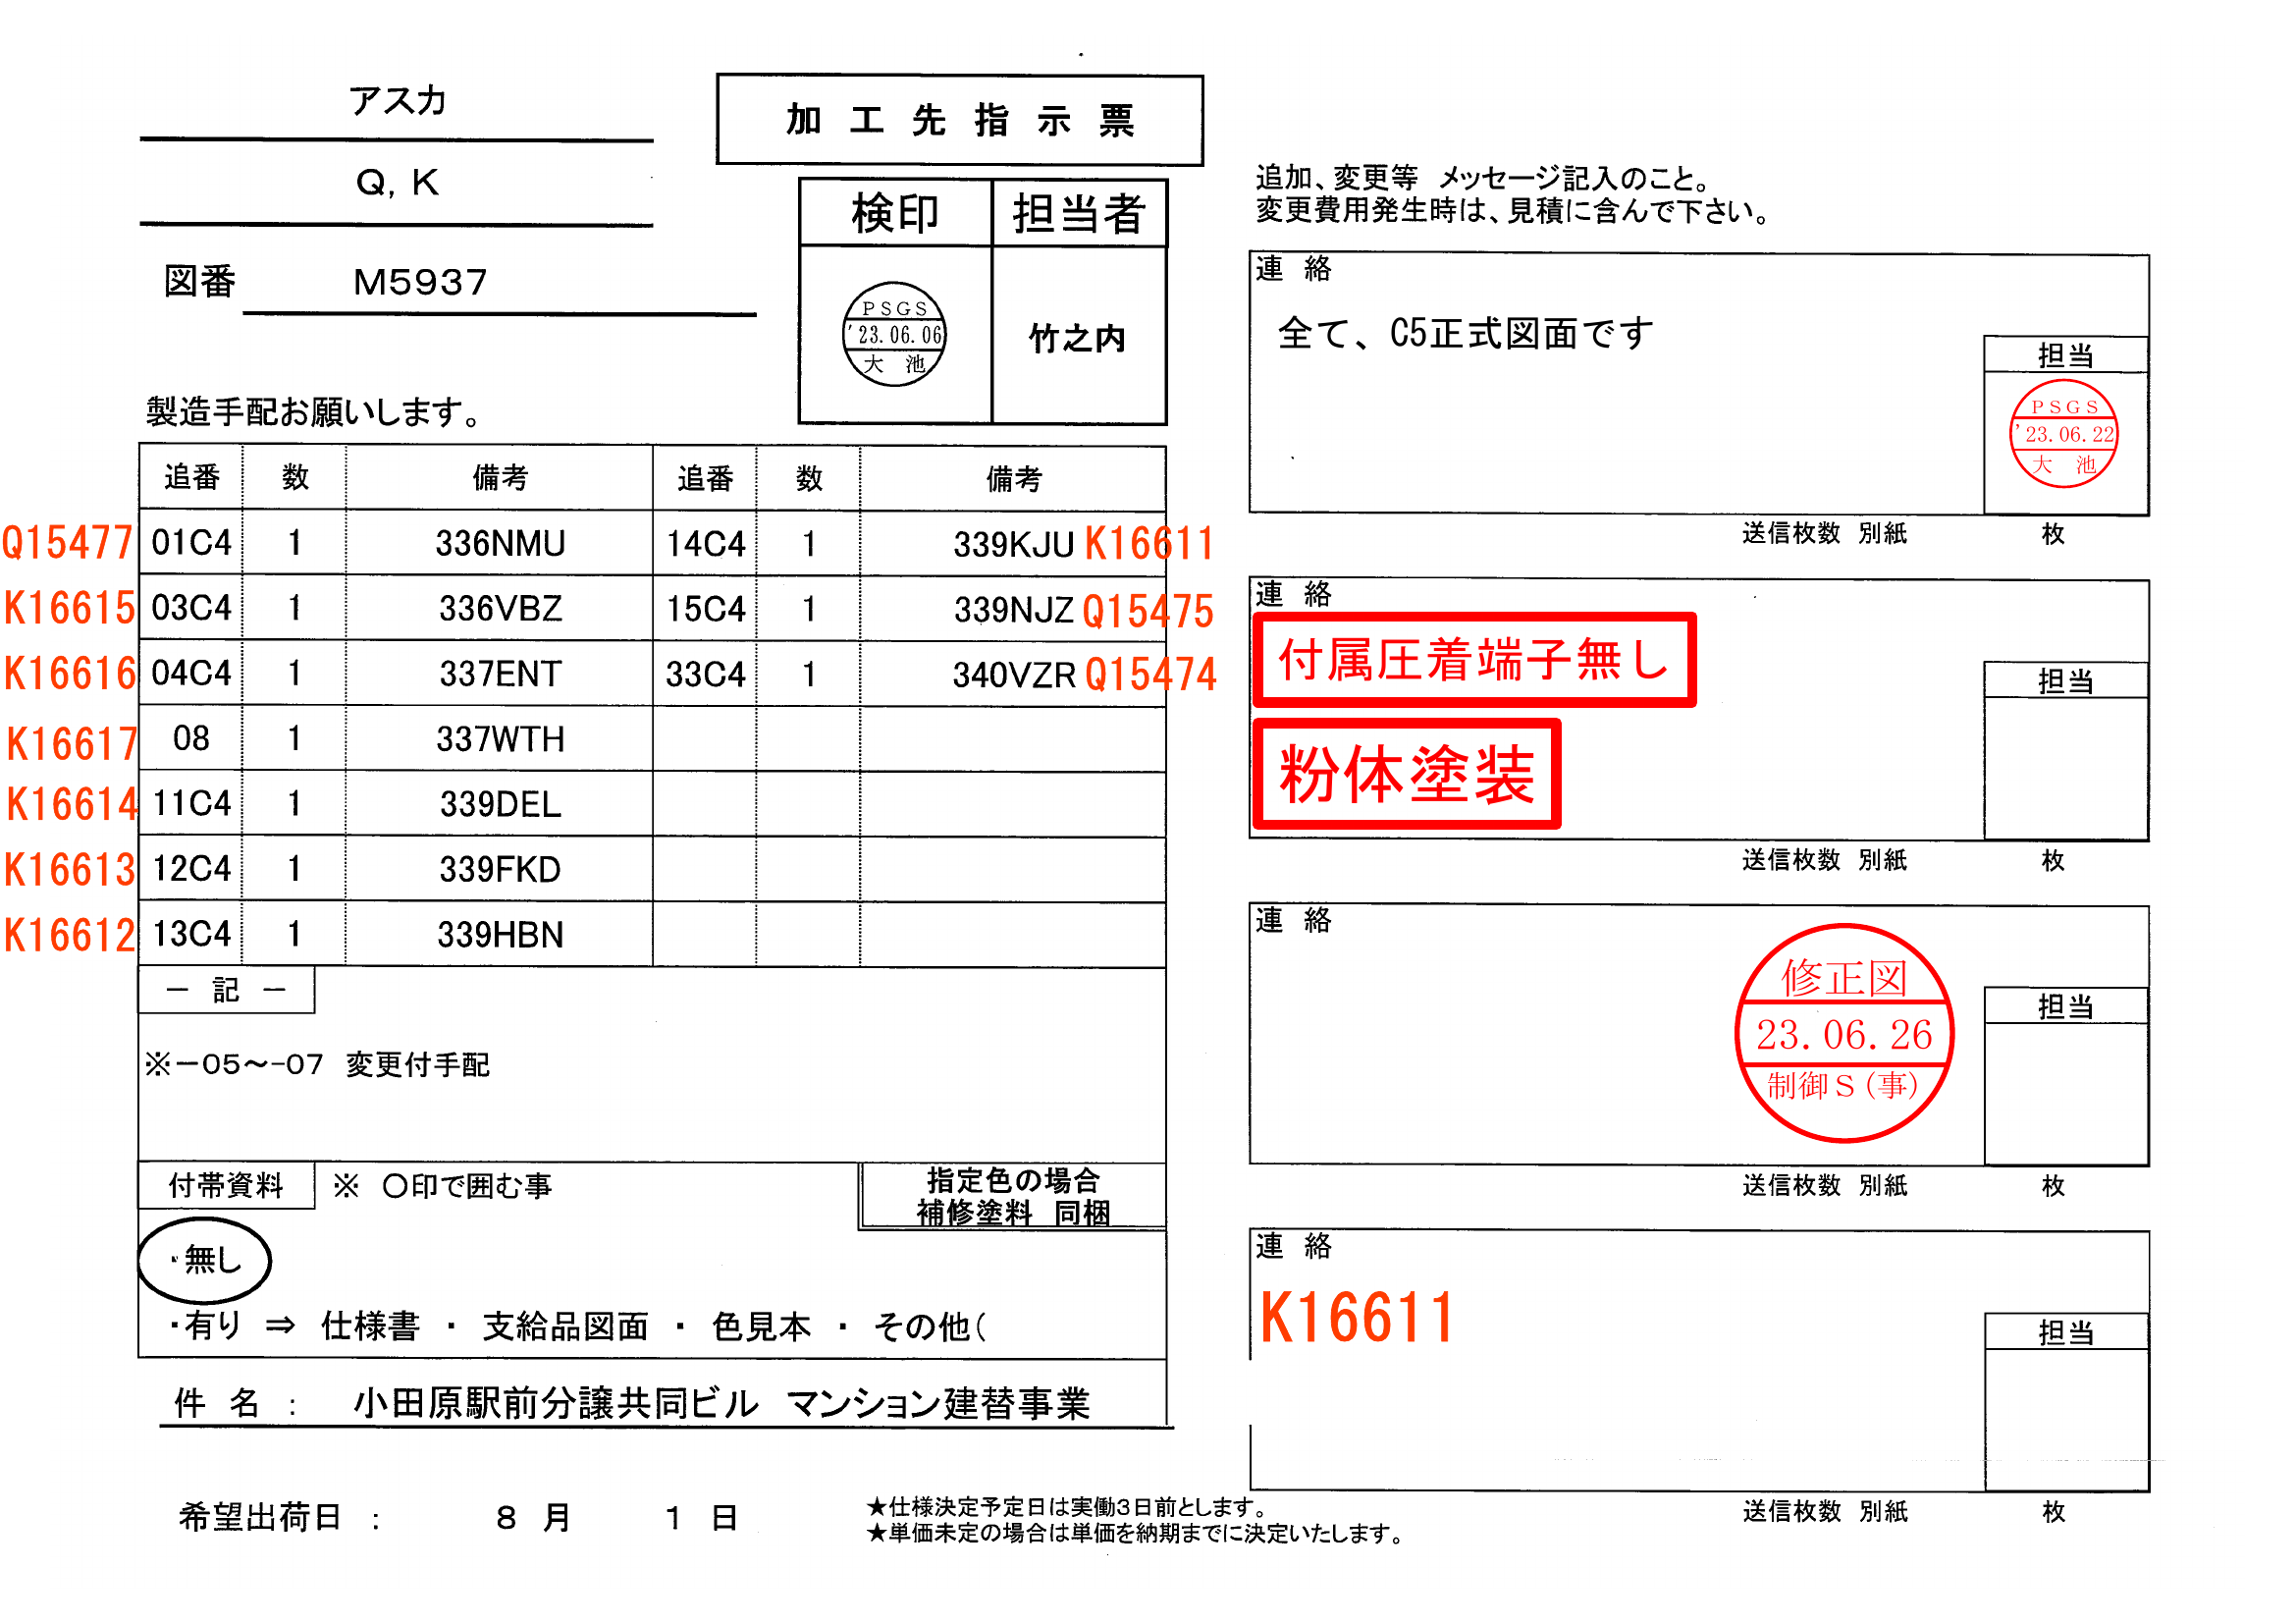

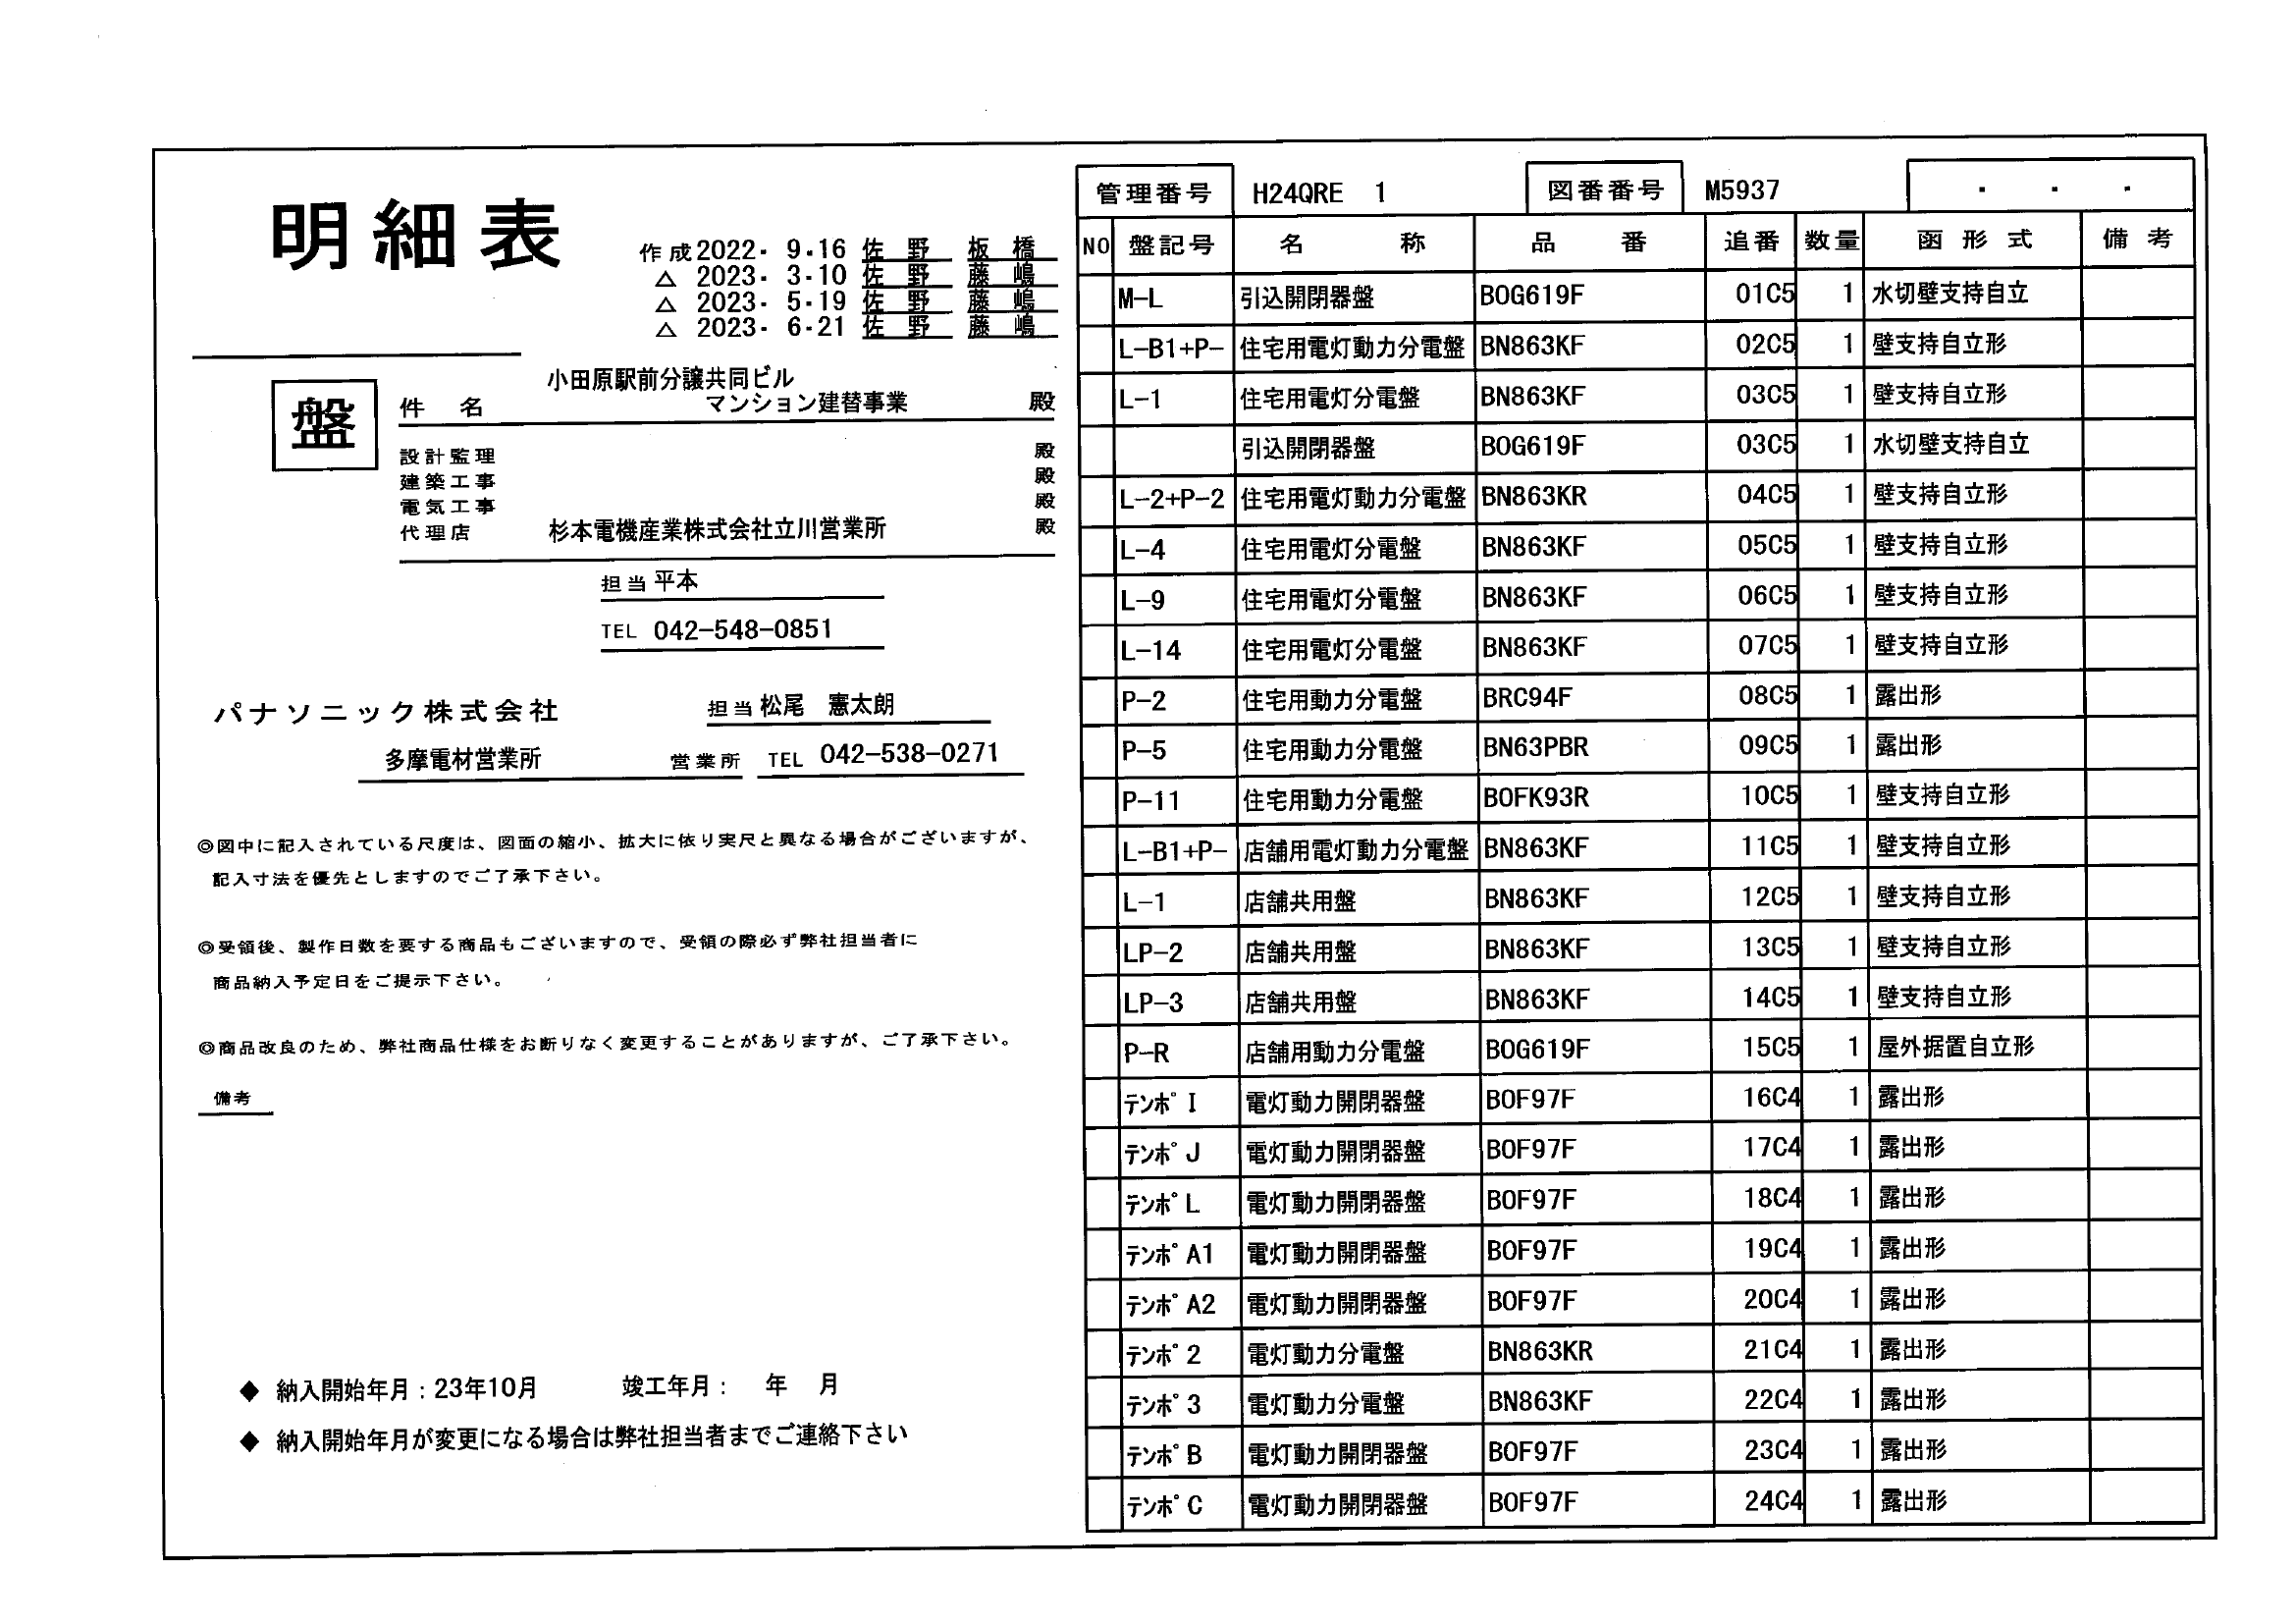

{"statusCode": 200, "body": "{\"message\": \"Created and saved diff image\"}"}


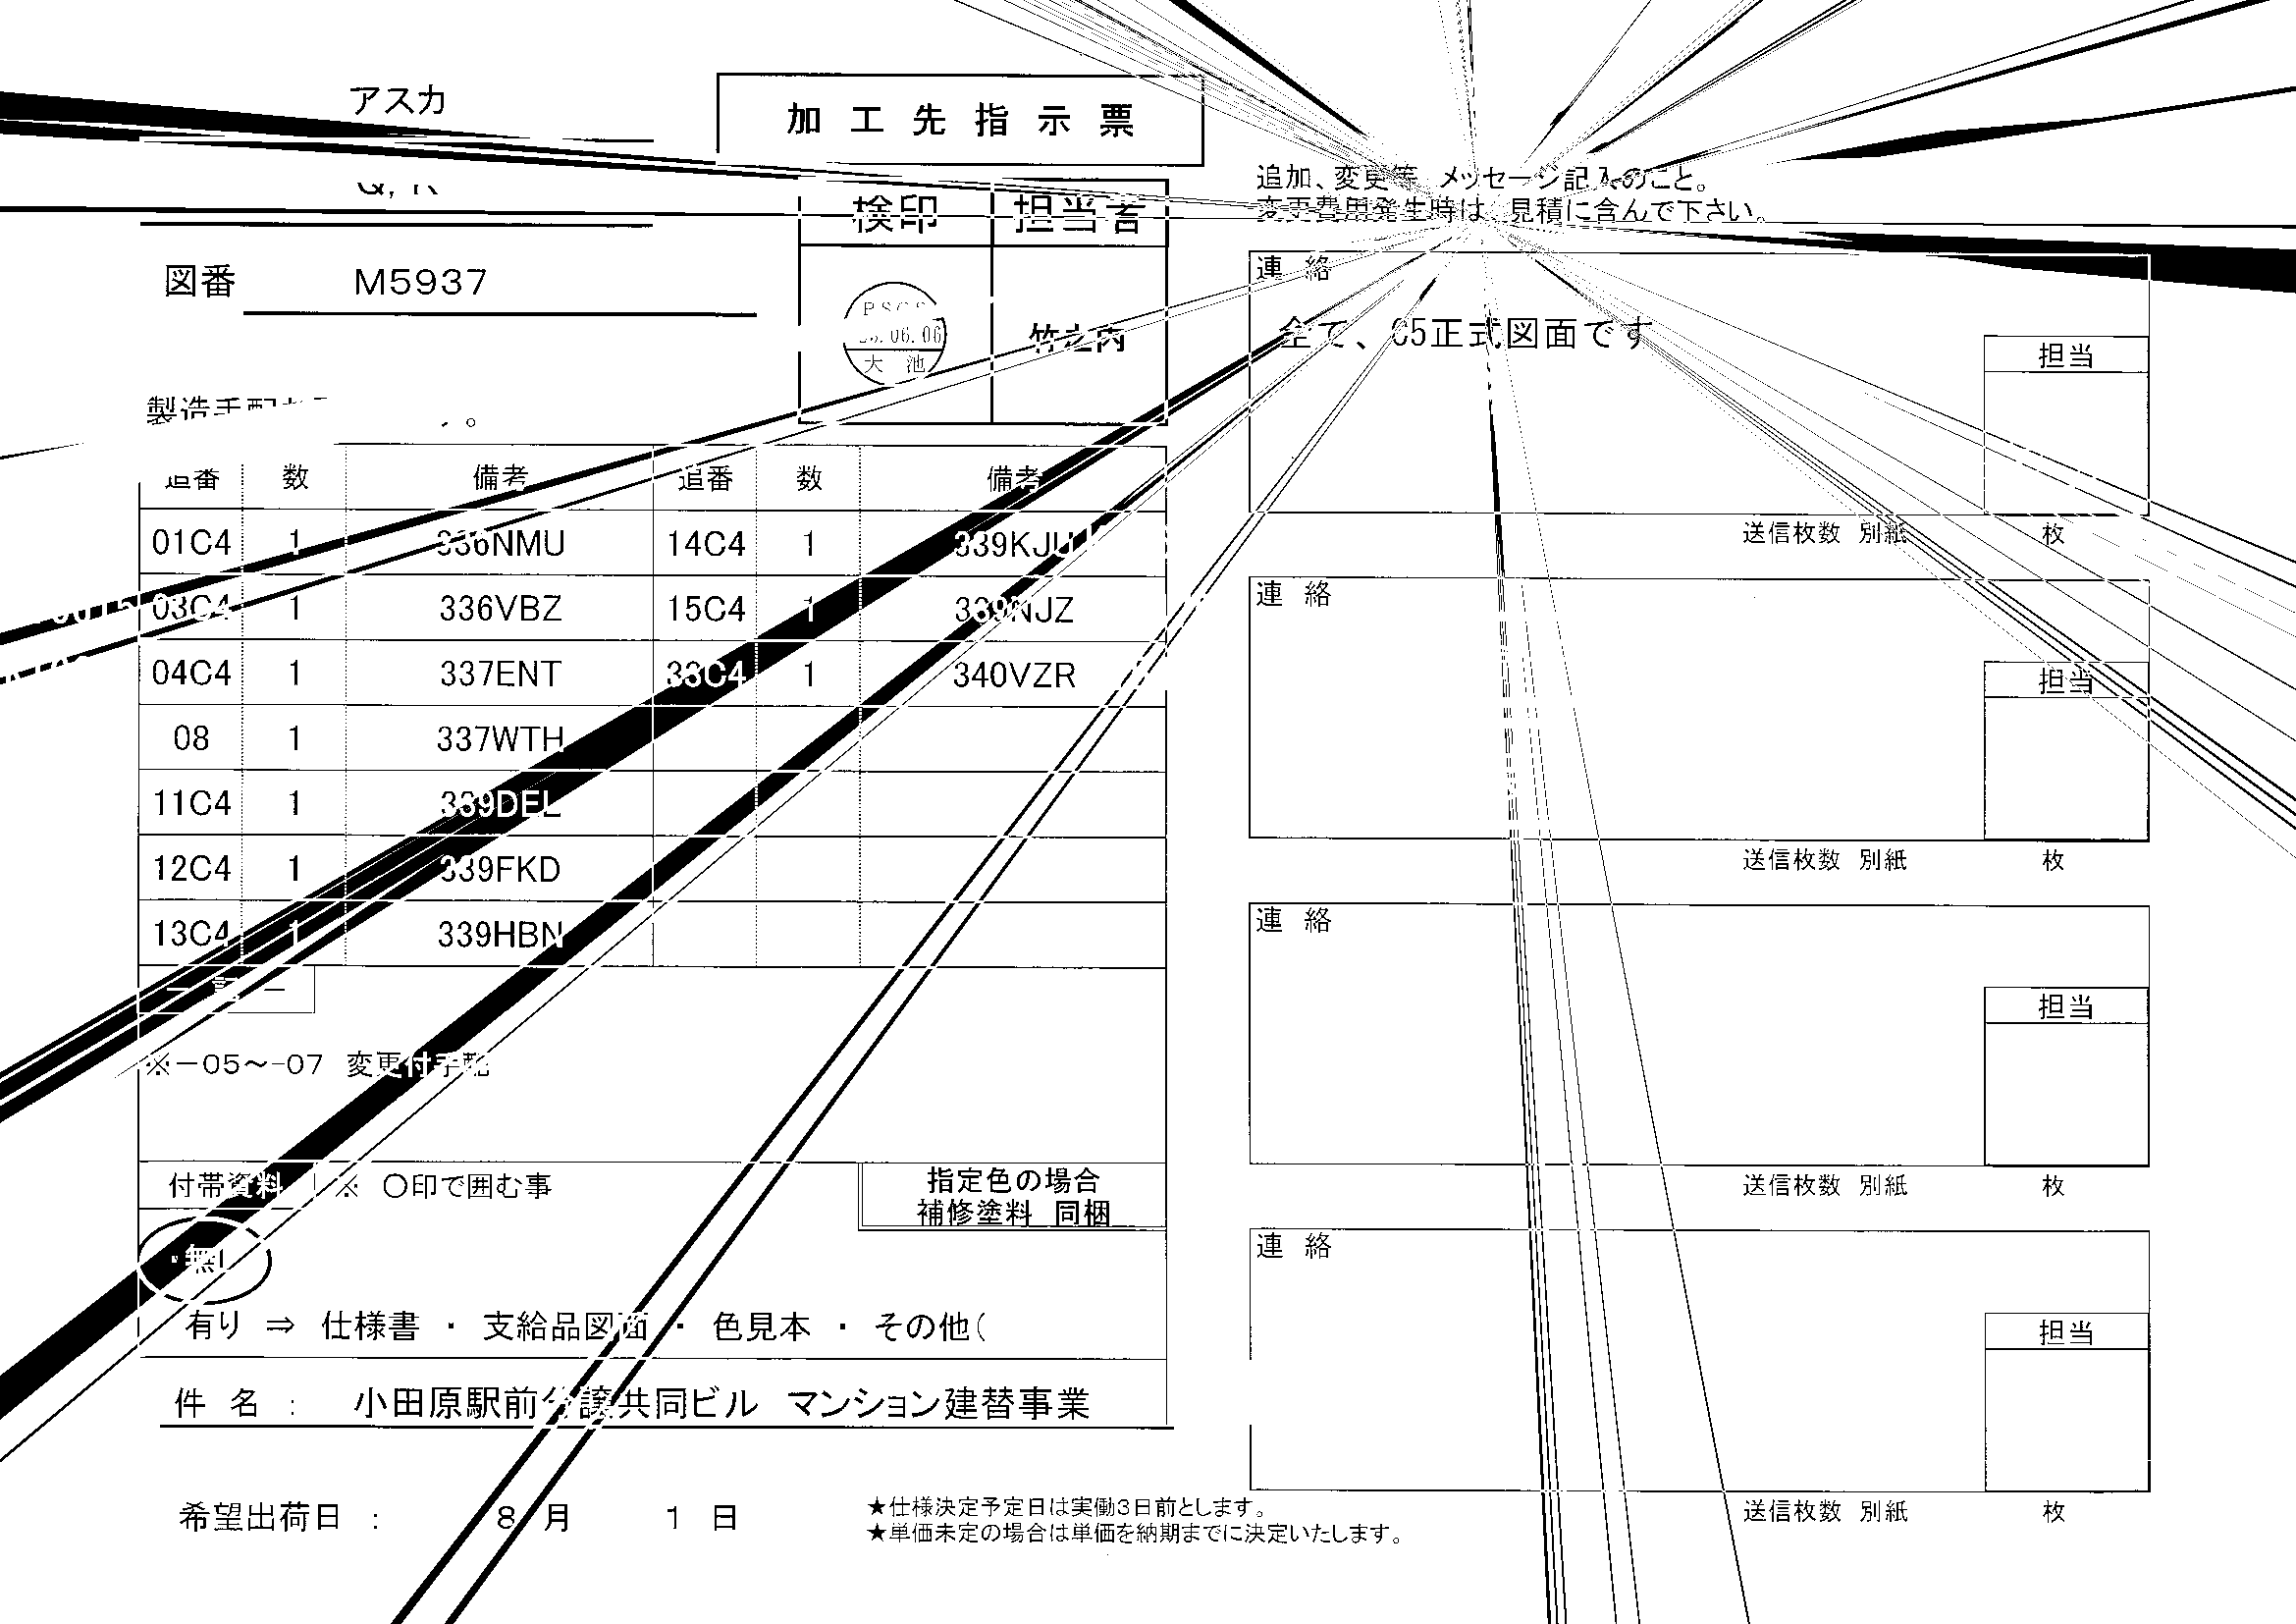

In [12]:
if __name__ == '__main__':
    main(payload=payload)